In [2]:
import numpy as np
from PIL import Image
import glob
from matplotlib import pyplot as plt
import math
from matplotlib import colors as mcolors

In [3]:
def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

In [4]:
def equi_coord(im,pano_W,pano_H,k_W,k_H,u,v): 
        
    fov_w = k_W*np.deg2rad(360/pano_W)
    focal = (float(k_W)/2) / np.tan(fov_w/2)
    c_x = 0
    c_y = 0
    phi, theta = ((u- pano_W/2 -0.5)/pano_W * math.pi *2, -(v- pano_H/2 -0.5)/pano_H * math.pi)
    ROT = rotation_matrix((0,1,0),phi)
    ROT = np.matmul(ROT,rotation_matrix((1,0,0),theta))#np.eye(3)

    h_range = np.array(range(k_H))
    w_range = np.array(range(k_W))
    w_ones = (np.ones(k_W))
    h_ones = (np.ones(k_H))
    h_grid = np.matmul(np.expand_dims(h_range,-1),np.expand_dims(w_ones,0))+0.5-float(k_H)/2
    w_grid = np.matmul(np.expand_dims(h_ones,-1),np.expand_dims(w_range,0))+0.5-float(k_W)/2
    
    K=np.array([[focal,0,c_x],[0,focal,c_y],[0.,0.,1.]])
    inv_K = np.linalg.inv(K)
    rays = np.stack([w_grid,h_grid,np.ones(h_grid.shape)],0)
    rays = np.matmul(inv_K,rays.reshape(3,k_H*k_W))
    rays /= np.linalg.norm(rays,axis=0,keepdims=True)
    rays = np.matmul(ROT,rays)
    rays=rays.reshape(3,k_H,k_W)
    
    theta = np.arctan2(rays[0,...],rays[2,...])
    phi = np.arcsin(np.clip(rays[1,...],-1,1))
    PI = np.pi
    y = pano_H*(phi + 0.5*PI)/PI 
    x = pano_W*0.5*(theta/PI+1) 
    
    roi_y = h_grid+v
    roi_x = w_grid+u

    new_roi_y = (y)+0.5
    new_roi_x = (x)+0.5

    colors = np.random.rand(len(roi_x.flatten()))
    imgplot = plt.imshow(im)
    plt.scatter( roi_x.flatten(), roi_y.flatten(), s=2, c='r', alpha=0.5)
    plt.scatter( new_roi_x.flatten(), new_roi_y.flatten(), s=2, c='b', alpha=0.5)
    plt.show()

    return 

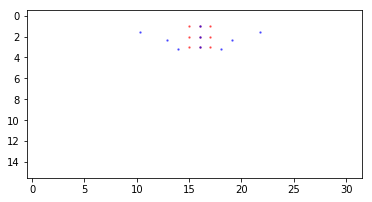

In [16]:
im = np.random.rand(16,32,3)*0+1
pano_H, pano_W,_ = im.shape
kernel = np.array(np.random.rand(3,3))
k_H, k_W = kernel.shape 
u, v = (16,2)# application center in pixels

equi_coord(im,pano_W,pano_H,k_W,k_H,u,v)

In [ ]:
def equi_coord(pano_W,pano_H,k_W,k_H,u,v,alpha=-1): 
    #pix = np.pi*2/pano_W
    fov_w = k_W * np.deg2rad(360./float(pano_W))
    if alpha>0:
        print(fov_w)
        assert fov_w<=alpha # kernel resolution is less or equal to the image resolution
        fov_w = alpha
    focal = (float(k_W)/2) / np.tan(fov_w/2)
    c_x = 0
    c_y = 0

    u_r, v_r = u, v #u+0.5, v+0.5
    u_r, v_r = u_r-float(pano_W)/2.,v_r-float(pano_H)/2.
    #phi, theta = ((u- pano_W/2 -0.5)/pano_W * math.pi *2, -(v- pano_H/2 -0.5)/pano_H * math.pi)
    phi, theta = u_r/(pano_W) * (np.pi) *2, -v_r/(pano_H) * (np.pi)
    #phi, theta = u_r/(pano_W-1) * (np.pi*2-pix), -v_r/(pano_H-1) * (np.pi-pix)

    ROT = rotation_matrix((0,1,0),phi)
    ROT = np.matmul(ROT,rotation_matrix((1,0,0),theta))#np.eye(3)

    h_range = np.array(range(k_H))
    w_range = np.array(range(k_W))
    w_ones = (np.ones(k_W))
    h_ones = (np.ones(k_H))
    h_grid = np.matmul(np.expand_dims(h_range,-1),np.expand_dims(w_ones,0))+0.5-float(k_H)/2
    w_grid = np.matmul(np.expand_dims(h_ones,-1),np.expand_dims(w_range,0))+0.5-float(k_W)/2

    K=np.array([[focal,0,c_x],[0,focal,c_y],[0.,0.,1.]])
    inv_K = np.linalg.inv(K)
    rays = np.stack([w_grid,h_grid,np.ones(h_grid.shape)],0)
    rays = np.matmul(inv_K,rays.reshape(3,k_H*k_W))
    rays /= np.linalg.norm(rays,axis=0,keepdims=True)
    rays = np.matmul(ROT,rays)
    rays=rays.reshape(3,k_H,k_W)

    phi = np.arctan2(rays[0,...],rays[2,...])
    theta = np.arcsin(np.clip(rays[1,...],-1,1))
    x = (pano_W)/(2.*np.pi)*phi +float(pano_W)/2.
    y = (pano_H)/(np.pi)*theta +float(pano_H)/2.

    roi_y = h_grid+v_r +float(pano_H)/2.
    roi_x = w_grid+u_r +float(pano_W)/2.

    new_roi_y = (y) 
    new_roi_x = (x) 
    
    return roi_x, roi_y, new_roi_x, new_roi_y
#     offsets_x = (new_roi_x - roi_x)
#     offsets_y = (new_roi_y - roi_y)

#     return offsets_x, offsets_y
